# INDIAN PINES CLUSTERING

## Dataset Description:

This scene was gathered by AVIRIS sensor over the Indian Pines test site in North-western Indiana and consists of 145\times145 pixels and 224 spectral reflectance bands in the wavelength range 0.4–2.5 10^(-6) meters. This scene is a subset of a larger one. The Indian Pines scene contains two-thirds agriculture, and one-third forest or other natural perennial vegetation. There are two major dual lane highways, a rail line, as well as some low density housing, other built structures, and smaller roads. Since the scene is taken in June some of the crops present, corn, soybeans, are in early stages of growth with less than 5% coverage. The ground truth available is designated into sixteen classes and is not all mutually exclusive. We have also reduced the number of bands to 200 by removing bands covering the region of water absorption: [104-108], [150-163], 220. Indian Pines data are available through Pursue's univeristy MultiSpec site.

## Task Breakdown
1. Read complete Indian pines data in Python.
2. If required, do some pre-processing (This is entirely up to you and you may skip it if you want).
3. Use any clustering algorithm of your choice to cluster the Indian pines data. Again, algorithm
and number of clusters is up to you but please make sure to describe your choice in the report.
4. Display clustered Indian pines dataset and include this in your report.
5. Identify the cluster with least number of pixels.

# NOTE: Jumpy Directly to final method and skip experiments
[HERE](#FINAL-METHOD)

## Imports

In [2]:
import tqdm

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline

In [4]:
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

np.random.seed(42)

In [5]:
import utils
from time import time
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection, neighbors)

---

## Reading the Dataset

In [13]:
DATASET_DIR = "./dataset"
dirs = os.listdir(DATASET_DIR)

['Indian_pines_corrected.mat', 'Indian_pines_gt.mat', 'Indian_pines.mat']

In [195]:
Indian_pines = scipy.io.loadmat(os.path.join(DATASET_DIR, "Indian_pines.mat"))['indian_pines']
Indian_pines_corrected = scipy.io.loadmat(os.path.join(DATASET_DIR, "Indian_pines_corrected.mat"))["indian_pines_corrected"]
Indian_pines_gt = scipy.io.loadmat(os.path.join(DATASET_DIR, "Indian_pines_gt.mat"))["indian_pines_gt"]

In [166]:
feature_vec_len = Indian_pines_corrected.shape[-1]
print("Scene shape:\t", Indian_pines[:, :, 0].shape)
print("Feature vector length:\t", feature_vec_len)

Scene shape:	 (145, 145)
Feature vector length:	 220


Note: I will be using the "Indian_pines_corrected.mat" file for further experiments as it has reduced dimensionality and will help accuracy as move forward. Processing will also be faster as feature length is reduced

---

# EDA

## Applying TSNE to see how seperable the classes are

In [65]:
np.unique(Indian_pines_gt)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

Note: Total number of unique classes in the ground truth. Note that this should be the baseline number of clusters for our clustering algorithm. Although this number may vary as the distribution of ground truth classes may be heavily skewed and hence may effect the clustering algorithm

### Lets apply tsne on the entire unprocessed dataset and visualise the results

In [539]:
X = Indian_pines_corrected
# Flatten the 145 x 145 signal so that the 200 channels are found as a row/vector
X = X.reshape(-1, X.shape[-1])
n_samples, n_features = X.shape

In [192]:
# t-SNE embedding
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

Computing t-SNE embedding


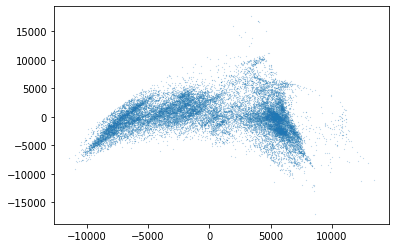

In [193]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha = 1, s = 0.01)

Note: Initial Analysis suggests the classes are not easily seperable even with TSNE which does not have a linear constraint. So we continue with more preprocessing

### Lets apply tsne after processing the entire dataset using normalisation

In [544]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in tqdm.tqdm(range(X.shape[0])):
        plt.scatter(X[i, 0], X[i, 1],color=plt.cm.Set1(y[i] / 10.))

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [541]:
y = Indian_pines_gt
y = y.reshape((-1))

In [542]:
# Standardize the feature vectors

# X_norm = (X - np.min(X))/np.ptp(X)
# X_norm_2 = X_norm * X_norm
# avr =  X_norm.mean()
# std =  np.sqrt(X_norm_2.mean() - avr**2)
# X_standard = (X_norm - avr) / std

X_standard = StandardScaler().fit_transform(X)

In [543]:
# t-SNE embedding
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X_standard)

Computing t-SNE embedding


100%|██████████| 21025/21025 [22:17<00:00, 15.72it/s]


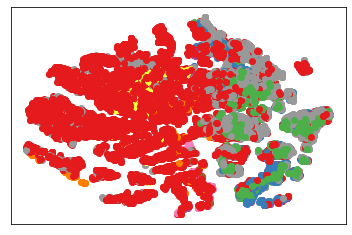

In [545]:
plot_embedding(X_tsne, y)

Computing PCA projection


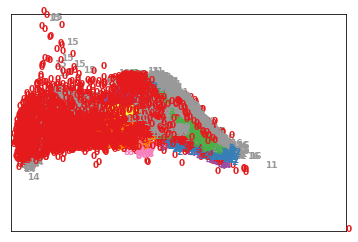

In [329]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X_standard)
plot_embedding(X_pca, y)

Note: With some standardization we can see that the data has seperation among classes although the class 0 is quite prevalent over image features. We will move onto PCA analysis and see how many dimensions we can dispose of. Also note that this image does not show the extent of skewness of classes. Lets see that first

(array([10776.,    46.,  1428.,   830.,   237.,   483.,   730.,    28.,
          478.,    20.,   972.,  2455.,   593.,   205.,  1265.,   386.,
           93.]),
 array([ 0.        ,  0.94117647,  1.88235294,  2.82352941,  3.76470588,
         4.70588235,  5.64705882,  6.58823529,  7.52941176,  8.47058824,
         9.41176471, 10.35294118, 11.29411765, 12.23529412, 13.17647059,
        14.11764706, 15.05882353, 16.        ]),
 <BarContainer object of 17 artists>)

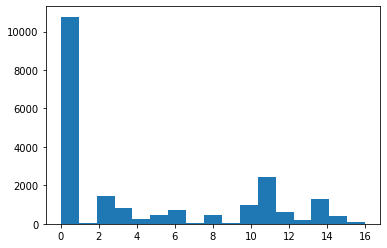

In [219]:
plt.hist(y, bins=17)

Note the 0 class has over 10000 instances. This skewness will be detrimental towards our clustering algoirthm if this class is not properly seperated. Density will play a large role here as well. Density based clustering could be an option

---

## PCA + Kmeans

In [442]:
def validate_kmeans(estimator, name, data, labels, sample_size = 1000, print_all=False):
    t0 = time()
    estimator.fit(data)
    if print_all:
        print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
              % (name, (time() - t0), estimator.inertia_,
                 metrics.homogeneity_score(labels, estimator.labels_),
                 metrics.completeness_score(labels, estimator.labels_),
                 metrics.v_measure_score(labels, estimator.labels_), 
                 metrics.adjusted_rand_score(labels, estimator.labels_), #ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
                 metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
                 metrics.silhouette_score(data, estimator.labels_,
                                          metric='euclidean',
                                          sample_size=sample_size))) # The best value is 1 and the worst value is -1. 

    return metrics.homogeneity_score(labels, estimator.labels_), metrics.completeness_score(labels, estimator.labels_)

In [444]:
## PREPROCESSING
X = Indian_pines_corrected
X = X.reshape(-1, X.shape[-1])

# Standardising the data to be mean centered and unit variance. Note that i follow the standardisation as done in this repo https://gitlab.inria.fr/naudeber/DeepHyperX
data = StandardScaler().fit_transform(X)

n_samples, n_features = data.shape
n_classes = len(np.unique(y))

y = Indian_pines_gt
y = y.reshape((-1))
labels = y

### Lets Run 4 different variants of the Kmeans algorithm with 17 classes as these are the amount of classes in GT. And keep an eye on the homogenity score as that is the most obvious metric to look at.

Note: This number of clusters may be detrimnetal to the clustering algorithm because of the density of 0 class

Note on homogenity score: ```A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class (as found on this link: 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)
```

In [345]:
estimator = KMeans(init='k-means++', n_clusters=n_classes, n_init=10)
h_score, c_score = validate_kmeans(estimator, name="k-means++", data=data, labels=labels)
print("Kmeans++ | 17 classes, Homogenity Score: ", h_score)
print("Kmeans++ | 17 classes, Completeness Score: ", c_score)

h_score, c_score = validate_kmeans(KMeans(init='random', n_clusters=n_classes, n_init=10),
              name="random", data=data, labels=labels)
print("Random initial centroids | 17 classes, Homogenity Score: ", h_score)
print("Random initial centroids | 17 classes, Completenees Score: ", c_score)

pca = PCA(n_components=n_classes).fit(data)
h_score, c_score = validate_kmeans(KMeans(init=pca.components_, n_clusters=n_classes, n_init=1),
              name="PCA-based",
              data=data, labels=labels)
print("Initialised with PCA Components | 17 componenets | 17 classes, Homogenity Score: ", h_score)
print("Initialised with PCA Components | 17 componenets | 17 classes, Completeness Score: ", c_score)

data_proj = PCA(n_components=n_classes).fit_transform(data)
estimator = KMeans(init='k-means++', n_clusters=n_classes, n_init=10)
h_score, c_score = validate_kmeans(estimator, name="k-means++", data=data_proj, labels=labels)
print("Initialised Kmeans++ | Projected Feature Vectors | 17 componenets | 17 classes, Homogenity Score: ", h_score)
print("Initialised Kmeans++ | Projected Feature Vectors | 17 componenets | 17 classes, Completeness Score: ", c_score)

Kmeans++ | 17 classes, Homogenity Score:  0.36617811906988856
Kmeans++ | 17 classes, Completeness Score:  0.36617811906988856
Random initial centroids | 17 classes, Homogenity Score:  0.3653839152662964
Random initial centroids | 17 classes, Completenees Score:  0.3653839152662964
Initialised with PCA Components | 17 componenets | 17 classes, Homogenity Score:  0.3574293018654008
Initialised with PCA Components | 17 componenets | 17 classes, Completeness Score:  0.3574293018654008
Initialised Kmeans++ | Projected Feature Vectors | 17 componenets | 17 classes, Homogenity Score:  0.3631764587708966
Initialised Kmeans++ | Projected Feature Vectors | 17 componenets | 17 classes, Completeness Score:  0.3631764587708966


### FINDINGS: None of the above give a great rise in our validation scores. Let explore further

---

## Finding the right parameters

#### Searching for  right number of components

In [378]:
pca_estimator_h_scores = []
pca_estimator_c_scores = []

# Number of cluster
max_components = 50
stride = 2
n_clusters = 17

y = list(range(2, max_components, stride))

for comp in tqdm.tqdm(y):
    data_proj = PCA(n_components=comp).fit_transform(data)
    pca_estimator = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    h_score, c_score = validate_kmeans(pca_estimator, name="k-means++", data=data_proj, labels=labels)
    pca_estimator_h_scores.append(h_score)
    pca_estimator_c_scores.append(c_score)

100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Text(0, 0.5, 'H Score')

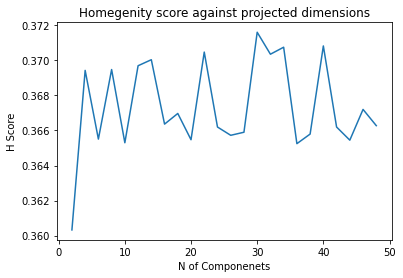

In [379]:
plt.plot(y, pca_estimator_h_scores)
plt.title("Homegenity score against projected dimensions")
plt.xlabel("N of Componenets")
plt.ylabel("H Score")

Note: From the given graph the empirically best value would be around 30 ~ 32. Lets use this in the next experiment. Note that this number is also found to be optimal in [1]

[1]: HybridSN: Exploring 3D-2D CNN Feature Hierarchy for Hyperspectral Image Classification

#### Searching for  right number of classes

In [445]:
simple_estimator_h_scores = []
pca_estimator_h_scores = []

simple_estimator_c_scores = []
pca_estimator_c_scores = []

optimal_n_components = 30

# Number of cluster
max_clusters = 50
y = list(range(1,max_clusters))

for clust in tqdm.tqdm(y):
    simple_estimator = KMeans(init='k-means++', n_clusters=clust, n_init=10)
    h_score, c_score = validate_kmeans(simple_estimator, name="k-means++", data=data, labels=labels)
    simple_estimator_h_scores.append(h_score)
    simple_estimator_c_scores.append(c_score)
    
    data_proj = PCA(n_components=optimal_n_components).fit_transform(data)
    pca_estimator = KMeans(init='k-means++', n_clusters=clust, n_init=10)
    h_score, c_score = validate_kmeans(pca_estimator, name="k-means++", data=data_proj, labels=labels)
    pca_estimator_h_scores.append(h_score)
    pca_estimator_c_scores.append(c_score)

100%|██████████| 49/49 [07:29<00:00,  9.16s/it]


Text(0, 0.5, 'H Score')

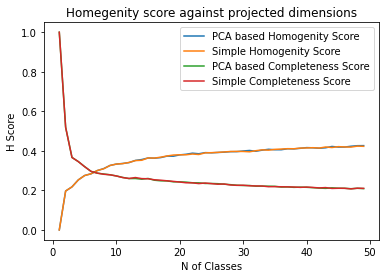

In [446]:
plt.plot(y, pca_estimator_h_scores, label="PCA based Homogenity Score")
plt.plot(y, simple_estimator_h_scores, label="Simple Homogenity Score")
plt.plot(y, pca_estimator_c_scores, label="PCA based Completeness Score")
plt.plot(y, simple_estimator_c_scores, label="Simple Completeness Score")
plt.legend()
plt.title("Homegenity score against projected dimensions")
plt.xlabel("N of Classes")
plt.ylabel("H Score")

Findings: It is to be noted that the HScore does not increase between the simple clustering and pca based clustering yet the number of features have been reduced from 200 to 30. The optimal number of clusters should be close to 30. 

#### Effect of Scaling, Standardisation and No Preprocessing

In [432]:
## PREPROCESSING
X = Indian_pines_corrected
X = X.reshape(-1, X.shape[-1])

# Standardising the data to be mean centered and unit variance. Note that i follow the standardisation as done in this repo https://gitlab.inria.fr/naudeber/DeepHyperX
data_standard = StandardScaler().fit_transform(X)
data_no_pre = X.copy()

n_samples, n_features = data.shape
n_classes = len(np.unique(y))

y = Indian_pines_gt
y = y.reshape((-1))
labels = y

In [437]:
optimal_n_components = 30
optimal_classes = 20

data_proj = PCA(n_components=optimal_n_components).fit_transform(data_no_pre)
pca_estimator = KMeans(init='k-means++', n_clusters=optimal_classes, n_init=10)
h_score, c_score = validate_kmeans(pca_estimator, name="k-means++", data=data_proj, labels=labels)
print("No Preprocessing Score: ", h_score)

data_proj = PCA(n_components=optimal_n_components).fit_transform(data_standard)
pca_estimator = KMeans(init='k-means++', n_clusters=optimal_classes, n_init=10)
h_score, c_score = validate_kmeans(pca_estimator, name="k-means++", data=data_proj, labels=labels)
print("Standardization: ", h_score)

No Preprocessing Score:  0.36034101456045853
Standardization:  0.3818534828658725


In [440]:
# 5 percent score improvement

---

# FINAL METHOD

### Reading Data

In [6]:
DATASET_DIR = "./dataset"
dirs = os.listdir(DATASET_DIR)

Indian_pines_corrected = scipy.io.loadmat(os.path.join(DATASET_DIR, "Indian_pines_corrected.mat"))["indian_pines_corrected"]
Indian_pines_gt = scipy.io.loadmat(os.path.join(DATASET_DIR, "Indian_pines_gt.mat"))["indian_pines_gt"]

### PREPROCESSING

In [8]:
X = Indian_pines_corrected
X = X.reshape(-1, X.shape[-1])

# Standardising the data to be mean centered and unit variance. Note that i follow the standardisation as done in this repo https://gitlab.inria.fr/naudeber/DeepHyperX
data = StandardScaler().fit_transform(X)

# Using groudtruth labels for validation only
y = Indian_pines_gt
y = y.reshape((-1))
labels = y

n_samples, n_features = data.shape
n_classes = len(np.unique(y))

# PCA Projection
optimal_n_components = 30
optimal_classes = 20
data_proj = PCA(n_components=optimal_n_components).fit_transform(data)

### CLUSTERING

In [9]:
# Clustering
estimator = KMeans(init='k-means++', n_clusters=optimal_classes, n_init=10)
estimator.fit(data_proj)
print("H-Score: ", metrics.homogeneity_score(labels, estimator.labels_))
print("Number of Classes: ", len(estimator.cluster_centers_))
print("Number of Projected Dimensions: ", data_proj.shape[-1])

H-Score:  0.37992216155305364
Number of Classes:  20
Number of Projected Dimensions:  30


### DISPLAYING CLUSTERS (in 3 dimensions)

In [10]:
# Display Clustered Pine Dataset
# To display the cluster we need to first project the entire scene down to 3 dimensions and then show labels
from mpl_toolkits.mplot3d import Axes3D

def scatter_embedding(X, y, title=None):
    plt.figure(figsize = (10, 10))
    ax = plt.subplot(111, projection='3d')
    
    for i in tqdm.tqdm(range(X.shape[0])):
        plt.scatter(X[i, 0], X[i, 1], X[i, 2], color=plt.cm.Set1(y[i] / 10.))
        
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

100%|██████████| 21025/21025 [01:13<00:00, 286.30it/s]


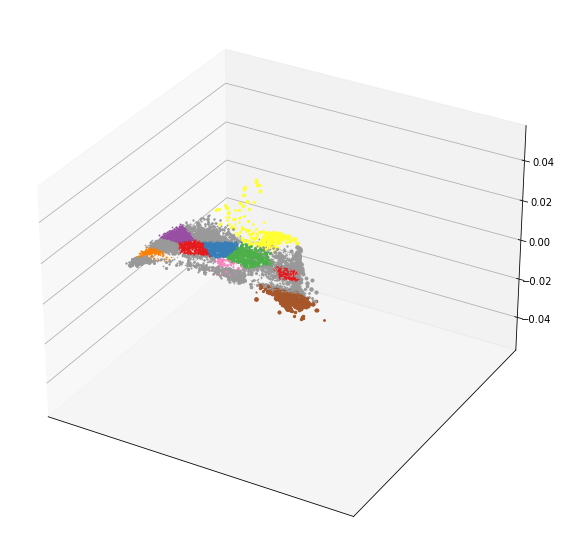

In [506]:
data_proj_3 = PCA(n_components=3).fit_transform(data)
scatter_embedding(data_proj_3, estimator.labels_)

In [20]:
def show_cluster_img(pred_labels):
#     colors = (np.random.rand(np.unique(pred_labels).shape[0], 3) * 255).astype(np.uint8)
    colors = np.random.rand(np.unique(pred_labels).shape[0], 3)
    uniques, c = np.unique(pred_labels, return_counts=True)
    
    
    mask_r = np.zeros(pred_labels.shape)
    mask_g = np.zeros(pred_labels.shape)
    mask_b = np.zeros(pred_labels.shape)
    for idx, u in enumerate(uniques):
        mask_r[np.where(pred_labels == u)] = colors[idx, 0]
        mask_g[np.where(pred_labels == u)] = colors[idx, 1]
        mask_b[np.where(pred_labels == u)] = colors[idx, 2]
    
    mask_r = mask_r.reshape((145, 145))
    mask_g = mask_g.reshape((145, 145))
    mask_b = mask_b.reshape((145, 145))
    
    mask = np.dstack((mask_r, mask_g, mask_b))
    plt.imshow(mask)

#### IMAGE CREATED BY MY METHOD

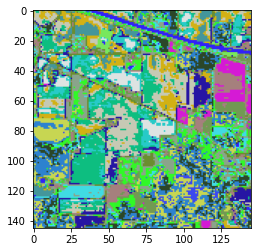

In [21]:
show_cluster_img(estimator.labels_)

#### IMAGE CREATED BY FROM THE ORIGINAL GROUND TRUTH LABLES

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
(145, 145, 3)


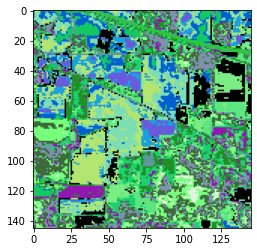

In [19]:
show_cluster_img(labels)

### Identitify Cluster With Least number of pixels

Estimated cluster with minimum pixel:  16
Below is the scene with the pixels activated which were clustered together


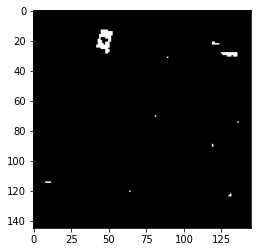

In [533]:
u, c = np.unique(estimator.labels_, return_counts=True)
minimum_occuring_class = u[np.argmin(c)]

mask = np.zeros(labels.shape)
mask[np.where(estimator.labels_ == minimum_occuring_class)] = 255

mask = mask.reshape((145, 145))

print("Estimated cluster with minimum pixel: ", minimum_occuring_class)

print("Below is the scene with the pixels activated which were clustered together")
plt.imshow(mask, cmap="gray")

Estimated cluster with maxmimum pixel:  13


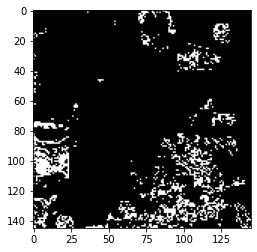

In [532]:
u, c = np.unique(estimator.labels_, return_counts=True)
max_occuring_class = u[np.argmax(c)]

mask = np.zeros(labels.shape)
mask[np.where(estimator.labels_ == max_occuring_class)] = 255

mask = mask.reshape((145, 145))

print("Estimated cluster with maxmimum pixel: ", max_occuring_class)
plt.imshow(mask, cmap="gray")